This code implements SARIMAX to consider exogen variables 
SARIMAX(p,d,q)(P,D,Q)m model
Reference: https://python.plainenglish.io/time-series-episode-3-arima-forecasting-with-exogenous-variables-6658f82170e4

In [32]:


from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
#from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import useful_functions as uf

#%matplotlib inline

In [33]:
plt.rcParams["figure.figsize"] = (8,4)

## Exploring seasonality 

In [34]:

# load the data
file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
#file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'
# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# define the target variable as the first column
target_variable = df_raw.columns[0]
# Convert all columns to float
df_raw = df_raw.astype('float64')

# Remove outliers? Define the threshold from 0 to 1 - float
#remove_outliers_threshold = np.nan
remove_outliers_threshold = 0.20



In [35]:
# Check if there is any NA value
#print(df_raw.isna().sum())

In [36]:
# If we want to remove outliers
if not pd.isna(remove_outliers_threshold):
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else:
    df_cleaned = df_raw.copy()

In [37]:
# Check if there is any NA value
#print(df_cleaned.isna().sum())

In [38]:
# Fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

# Define test and validation set sizes
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets

train_raw = df_adjusted[:-test_size] # This total trainning set will be used to train the final model
test_raw = df_adjusted[-test_size:]

In [39]:
# Let´s scale the dfs

#scaled_train, scaled_test, params = uf.scale_data(train_raw, test_raw, 'normalize')

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_raw)
scaled_test = scaler.transform(test_raw)
# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_adjusted.columns)
test = pd.DataFrame(scaled_test, columns=df_adjusted.columns)
# Include the index in the train and test sets
train.index = df_adjusted.index[:-test_size]
test.index = df_adjusted.index[-test_size:]

# define the exogenous variables as all except the target variable
# Subset df to get only the first column
exog_var_train = train.iloc[:, 1:].ffill()
exog_var_test = test.iloc[:, 1:].ffill()

In [40]:
# Find the best parameters using auto_arima function
# auto_model = auto_arima(train[target_variable], seasonal=True, m=12, trace=False,
#                         error_action='ignore', suppress_warnings=True, exog = exog_var_train)
auto_model = auto_arima(train[target_variable], 
                              start_p=0, start_q=0, 
                              max_p=5, max_q=5, 
                              m=12, 
                              start_P=0, start_Q=0, 
                              max_P=5, max_Q=5, 
                              seasonal=True, 
                              d=None, D=1,  
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False, 
                              exog = exog_var_train, max_order=10)

# Adjust the model with the best parameters and train it
model = SARIMAX(train[target_variable], order=auto_model.order, 
                seasonal_order=auto_model.seasonal_order, 
                exog = exog_var_train)

model_fit = model.fit(disp=False, maxiter=100)

print(model_fit.summary())

In [ ]:

# create forecasts on training set (to evaluate how the model behaves to known-training data)
forecasts_on_train_scaled = model_fit.predict()
# Predict for the test period
forecasts_on_test_scaled = model_fit.forecast(steps=len(test[target_variable]), exog = exog_var_test)

In [ ]:
# Let's reverse the scaling to get the real values
original_data_train = df_adjusted[:-test_size][target_variable]
original_data_test = df_adjusted[-test_size:][target_variable]
# Convert Pandas Series to NumPy arrays and reshape
forecasts_on_train_scaled_np = forecasts_on_train_scaled.to_numpy().reshape(-1, 1)
forecasts_on_train_scaled_np = np.repeat(forecasts_on_train_scaled_np,train.shape[1], axis=-1)
forecasts_on_test_scaled_np = forecasts_on_test_scaled.to_numpy().reshape(-1, 1)
forecasts_on_test_scaled_np = np.repeat(forecasts_on_test_scaled_np,test.shape[1], axis=-1)

# Inverse transform to get the real values
forecasts_on_train_all = scaler.inverse_transform(forecasts_on_train_scaled_np)
forecasts_on_test_all = scaler.inverse_transform(forecasts_on_test_scaled_np)

# Subset the forecast to get only the first column
forecasts_on_train = forecasts_on_train_all[:,0]
forecasts_on_test = forecasts_on_test_all[:,0]

# Convert to pandas dataframe and include the index
forecasts_on_train = pd.DataFrame(forecasts_on_train, index=train.index, columns=[target_variable])
forecasts_on_test = pd.DataFrame(forecasts_on_test, index=test.index, columns=[target_variable])


In [ ]:
# print the AIC of the model
print('AIC: ' , model_fit.aic)

mape_SARIMAX = mean_absolute_percentage_error(original_data_train,forecasts_on_train)
rmse_SARIMAX = np.sqrt(mean_squared_error(original_data_train,forecasts_on_train))
mae_SARIMAX = mean_absolute_error(original_data_train,forecasts_on_train)

print("Errors on training set: ")
print('MAPE_SARIMAX:', mape_SARIMAX)
print('RMSE_SARIMAX:', rmse_SARIMAX)
print('MAE_SARIMAX:', mae_SARIMAX)


AIC:  -425.39567659493866
Errors on training set: 
MAPE_SARIMAX: 3.8057353197683548
RMSE_SARIMAX: 18536.47968534791
MAE_SARIMAX: 7713.259215004742


In [ ]:
# print the AIC of the model
print('AIC: ' , model_fit.aic)

mape_SARIMAX = mean_absolute_percentage_error(original_data_test,forecasts_on_test)
rmse_SARIMAX = np.sqrt(mean_squared_error(original_data_test,forecasts_on_test))
mae_SARIMAX = mean_absolute_error(original_data_test,forecasts_on_test)

print("Errors on test set: ")
print('MAPE_SARIMAX:', mape_SARIMAX)
print('RMSE_SARIMAX:', rmse_SARIMAX)
print('MAE_SARIMAX:', mae_SARIMAX)


AIC:  -425.39567659493866
Errors on test set: 
MAPE_SARIMAX: 3.2282908298674484
RMSE_SARIMAX: 29390.64515967309
MAE_SARIMAX: 22687.149457123265


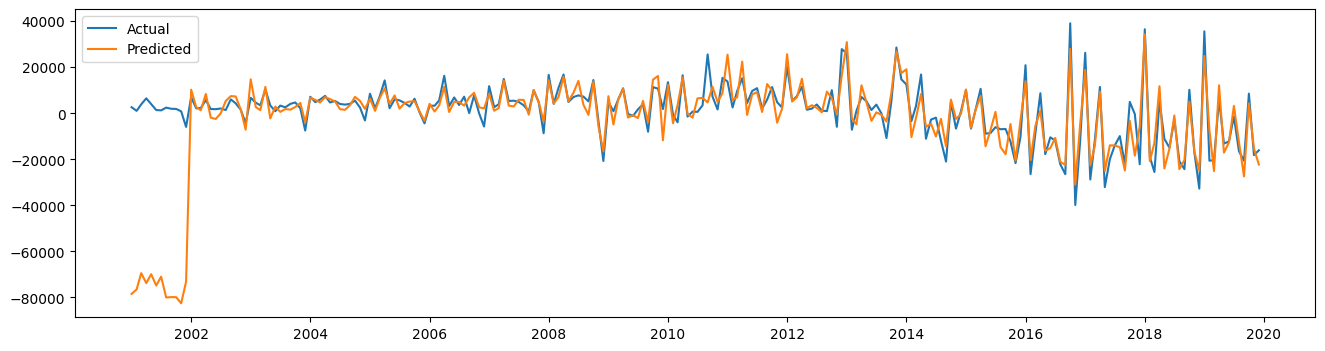

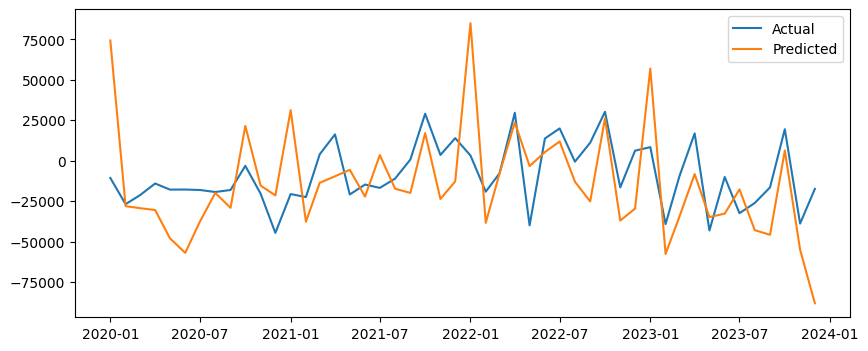

In [ ]:
# plot the train and test data against their corresponding forecasts

# on train data
plt.figure(figsize=(16,4))
plt.plot(original_data_train, label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

# on test data
plt.figure(figsize=(10,4))
plt.plot(original_data_test, label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()

To evaluate the results of the chart below, check this link: https://python.plainenglish.io/time-series-episode-3-arima-forecasting-with-exogenous-variables-6658f82170e4


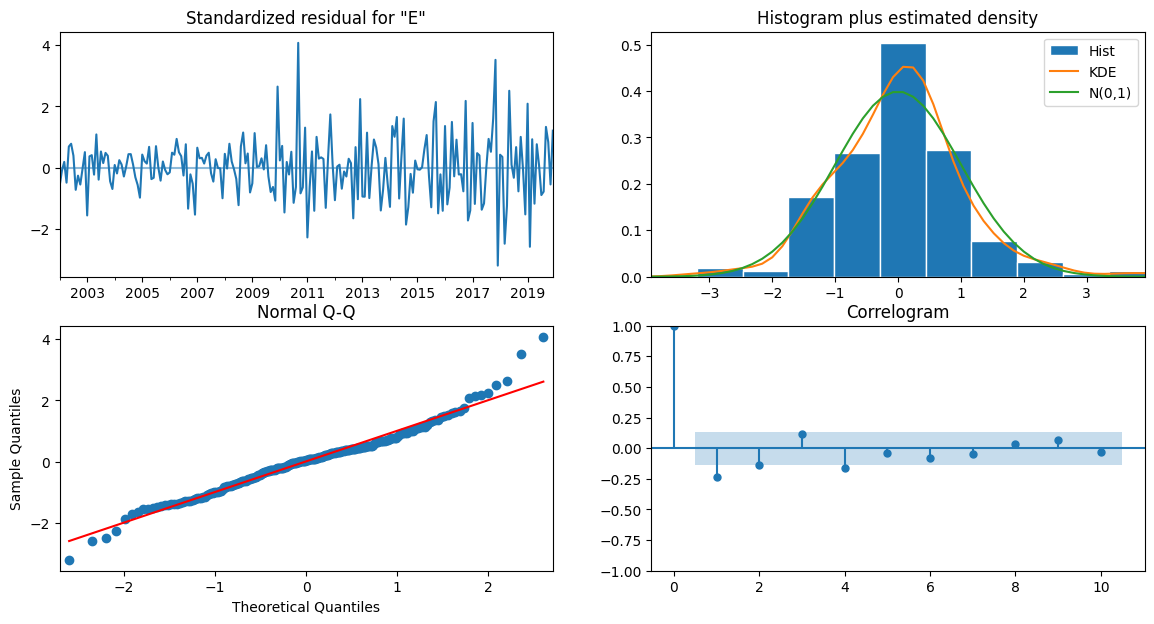

In [ ]:
model_fit.plot_diagnostics(figsize=(14,7))
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



# Prever a variável dependente usando o modelo

y = df_adjusted[target_variable]
# Y-pred is all variables but the target variable
# concatenate the dataframes
y_pred = pd.concat(
    [pd.DataFrame(forecasts_on_train, index=train.index, columns = [target_variable]),
     pd.DataFrame(forecasts_on_test, index=test.index, columns = [target_variable])], 
     axis=0)

# Calcular o R-quadrado ajustado
n = len(y)  # número de observações
k = exog_var_train.shape[1]  # número de variáveis independentes selecionadas
r2_adj = 1 - ((1 - r2_score(y, y_pred)) * (n - 1) / (n - k - 1))

# Exibir o percentual do comportamento da variável dependente explicado pelas variáveis independentes selecionadas
print(f"Percentual do comportamento da variável dependente explicado pelas variáveis independentes selecionadas: {r2_adj * 100:.2f}%")


ValueError: Input contains NaN.